In [35]:
import random
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm
import shap
import matplotlib.pyplot as plt 
import seaborn as sns

from catboost import CatBoostRegressor, Pool, cv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error 

plt.style.use('seaborn')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

SEED = 13
seed_everything(SEED)

# Loading Data

In [3]:
df_train = pd.read_csv('data/train.csv') # index_col='date'
df_test = pd.read_csv('data/test.csv') # index_col='date'

df_train['date'] = pd.to_datetime(df_train.date)
df_test['date'] = pd.to_datetime(df_test.date)

# Time Series Cross Validation

In [4]:
def performTimeSeriesCV(df_train, target, number_folds, model, metric, kwargs={}):
    dates = df_train.date.unique()
    k = len(dates) // number_folds

    metrics = []
 
    for i in range(1, number_folds):
        train_index = dates[:(k * i)]
        
        if i == number_folds - 1:
            val_index = dates[(k * i):]
        else:
            val_index = dates[(k * i):(k * (i + 1))]
        
        train = df_train[df_train.date.isin(train_index)]
        val = df_train[df_train.date.isin(val_index)]
       
        X_train = train.drop(columns=['date', 'target_revenue', 'target_income'])     
        y_train = train[target]

        X_val = val.drop(columns=['date', 'target_revenue', 'target_income']).values     
        y_val = val[target].values
        
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
        metrics.append(metric(y_val, model.predict(X_val),))
   
    return metrics

In [5]:
def SMAPE(y_true, y_pred):
    return (100 / y_true.size) * np.sum(2 * np.abs(y_pred - y_true) / (abs(y_true) + abs(y_pred)))

# Baseline

У нас в задаче две целевые переменные: revenue и income. Однако из-за того, что у них очень высокая корреляция, чтобы не дублировать весь код пока будем прогнозировать только Revenue. Когда определим оптимальную модель для revenue (оптимальные признаки и оптимальные гиперпараметры), то просто обучим такую же модель для income.

В качестве бейзлайн модели построим CatBoost с гиперпамраметрами по умолчанию.

In [6]:
cat_features = ['Company']
for cat_feature in cat_features:
    df_train[cat_features] = df_train[cat_features].astype('category')

In [7]:
CBr_baseline = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features, random_seed=SEED)

smape_baseline_cv = performTimeSeriesCV(df_train, 'target_revenue', 3, CBr_baseline, SMAPE)

0:	learn: 0.9404398	test: 0.9316932	best: 0.9316932 (0)	total: 60.1ms	remaining: 1m
1:	learn: 0.9248931	test: 0.9250487	best: 0.9250487 (1)	total: 61.9ms	remaining: 30.9s
2:	learn: 0.9093316	test: 0.9308796	best: 0.9250487 (1)	total: 64.3ms	remaining: 21.4s
3:	learn: 0.8922339	test: 0.9189636	best: 0.9189636 (3)	total: 66.3ms	remaining: 16.5s
4:	learn: 0.8754584	test: 0.9072097	best: 0.9072097 (4)	total: 68.9ms	remaining: 13.7s
5:	learn: 0.8672546	test: 0.8967683	best: 0.8967683 (5)	total: 71.6ms	remaining: 11.9s
6:	learn: 0.8569350	test: 0.8840295	best: 0.8840295 (6)	total: 73.4ms	remaining: 10.4s
7:	learn: 0.8532547	test: 0.8767109	best: 0.8767109 (7)	total: 75.6ms	remaining: 9.38s
8:	learn: 0.8354880	test: 0.8630160	best: 0.8630160 (8)	total: 77.1ms	remaining: 8.49s
9:	learn: 0.8243379	test: 0.8616743	best: 0.8616743 (9)	total: 79ms	remaining: 7.82s
10:	learn: 0.8108796	test: 0.8622038	best: 0.8616743 (9)	total: 80.4ms	remaining: 7.23s
11:	learn: 0.7984427	test: 0.8493020	best: 0.84

121:	learn: 0.3814912	test: 0.7345378	best: 0.7181145 (63)	total: 238ms	remaining: 1.71s
122:	learn: 0.3807735	test: 0.7357607	best: 0.7181145 (63)	total: 240ms	remaining: 1.71s
123:	learn: 0.3791407	test: 0.7359981	best: 0.7181145 (63)	total: 241ms	remaining: 1.7s
124:	learn: 0.3782242	test: 0.7408772	best: 0.7181145 (63)	total: 243ms	remaining: 1.7s
125:	learn: 0.3778679	test: 0.7406189	best: 0.7181145 (63)	total: 244ms	remaining: 1.69s
126:	learn: 0.3765766	test: 0.7422904	best: 0.7181145 (63)	total: 246ms	remaining: 1.69s
127:	learn: 0.3765523	test: 0.7423365	best: 0.7181145 (63)	total: 247ms	remaining: 1.68s
128:	learn: 0.3755792	test: 0.7430566	best: 0.7181145 (63)	total: 249ms	remaining: 1.68s
129:	learn: 0.3750997	test: 0.7442316	best: 0.7181145 (63)	total: 250ms	remaining: 1.68s
130:	learn: 0.3743175	test: 0.7443353	best: 0.7181145 (63)	total: 252ms	remaining: 1.67s
131:	learn: 0.3728500	test: 0.7454024	best: 0.7181145 (63)	total: 253ms	remaining: 1.67s
132:	learn: 0.3719292	t

269:	learn: 0.3205601	test: 0.7888806	best: 0.7181145 (63)	total: 433ms	remaining: 1.17s
270:	learn: 0.3204736	test: 0.7894158	best: 0.7181145 (63)	total: 434ms	remaining: 1.17s
271:	learn: 0.3204233	test: 0.7894503	best: 0.7181145 (63)	total: 436ms	remaining: 1.17s
272:	learn: 0.3203835	test: 0.7903323	best: 0.7181145 (63)	total: 437ms	remaining: 1.16s
273:	learn: 0.3203023	test: 0.7903223	best: 0.7181145 (63)	total: 438ms	remaining: 1.16s
274:	learn: 0.3201398	test: 0.7906812	best: 0.7181145 (63)	total: 439ms	remaining: 1.16s
275:	learn: 0.3199459	test: 0.7912539	best: 0.7181145 (63)	total: 440ms	remaining: 1.15s
276:	learn: 0.3199194	test: 0.7913286	best: 0.7181145 (63)	total: 441ms	remaining: 1.15s
277:	learn: 0.3199074	test: 0.7914027	best: 0.7181145 (63)	total: 442ms	remaining: 1.15s
278:	learn: 0.3198748	test: 0.7917286	best: 0.7181145 (63)	total: 444ms	remaining: 1.15s
279:	learn: 0.3197128	test: 0.7920669	best: 0.7181145 (63)	total: 445ms	remaining: 1.14s
280:	learn: 0.3196866

429:	learn: 0.3106921	test: 0.8209757	best: 0.7181145 (63)	total: 627ms	remaining: 831ms
430:	learn: 0.3106862	test: 0.8211808	best: 0.7181145 (63)	total: 628ms	remaining: 829ms
431:	learn: 0.3106561	test: 0.8212866	best: 0.7181145 (63)	total: 630ms	remaining: 828ms
432:	learn: 0.3106564	test: 0.8213309	best: 0.7181145 (63)	total: 631ms	remaining: 826ms
433:	learn: 0.3106266	test: 0.8214336	best: 0.7181145 (63)	total: 632ms	remaining: 824ms
434:	learn: 0.3106262	test: 0.8214766	best: 0.7181145 (63)	total: 633ms	remaining: 822ms
435:	learn: 0.3106095	test: 0.8214825	best: 0.7181145 (63)	total: 634ms	remaining: 820ms
436:	learn: 0.3106053	test: 0.8214939	best: 0.7181145 (63)	total: 636ms	remaining: 819ms
437:	learn: 0.3106050	test: 0.8215345	best: 0.7181145 (63)	total: 637ms	remaining: 817ms
438:	learn: 0.3105887	test: 0.8215397	best: 0.7181145 (63)	total: 638ms	remaining: 816ms
439:	learn: 0.3105598	test: 0.8216398	best: 0.7181145 (63)	total: 640ms	remaining: 814ms
440:	learn: 0.3104188

587:	learn: 0.3085947	test: 0.8338802	best: 0.7181145 (63)	total: 821ms	remaining: 575ms
588:	learn: 0.3085085	test: 0.8338963	best: 0.7181145 (63)	total: 823ms	remaining: 575ms
589:	learn: 0.3085014	test: 0.8338860	best: 0.7181145 (63)	total: 826ms	remaining: 574ms
590:	learn: 0.3084997	test: 0.8338990	best: 0.7181145 (63)	total: 827ms	remaining: 573ms
591:	learn: 0.3084929	test: 0.8338889	best: 0.7181145 (63)	total: 829ms	remaining: 571ms
592:	learn: 0.3084863	test: 0.8338791	best: 0.7181145 (63)	total: 830ms	remaining: 570ms
593:	learn: 0.3084875	test: 0.8339130	best: 0.7181145 (63)	total: 832ms	remaining: 569ms
594:	learn: 0.3084811	test: 0.8339034	best: 0.7181145 (63)	total: 834ms	remaining: 567ms
595:	learn: 0.3084808	test: 0.8338889	best: 0.7181145 (63)	total: 835ms	remaining: 566ms
596:	learn: 0.3084746	test: 0.8338796	best: 0.7181145 (63)	total: 836ms	remaining: 564ms
597:	learn: 0.3084744	test: 0.8338656	best: 0.7181145 (63)	total: 838ms	remaining: 563ms
598:	learn: 0.3084684

719:	learn: 0.3083657	test: 0.8346340	best: 0.7181145 (63)	total: 1.01s	remaining: 394ms
720:	learn: 0.3083658	test: 0.8346404	best: 0.7181145 (63)	total: 1.01s	remaining: 393ms
721:	learn: 0.3083660	test: 0.8346396	best: 0.7181145 (63)	total: 1.02s	remaining: 392ms
722:	learn: 0.3083661	test: 0.8346389	best: 0.7181145 (63)	total: 1.02s	remaining: 390ms
723:	learn: 0.3083662	test: 0.8346381	best: 0.7181145 (63)	total: 1.02s	remaining: 389ms
724:	learn: 0.3083663	test: 0.8346444	best: 0.7181145 (63)	total: 1.02s	remaining: 387ms
725:	learn: 0.3083663	test: 0.8346437	best: 0.7181145 (63)	total: 1.02s	remaining: 386ms
726:	learn: 0.3083664	test: 0.8346498	best: 0.7181145 (63)	total: 1.02s	remaining: 384ms
727:	learn: 0.3083665	test: 0.8346556	best: 0.7181145 (63)	total: 1.02s	remaining: 383ms
728:	learn: 0.3083684	test: 0.8346639	best: 0.7181145 (63)	total: 1.02s	remaining: 381ms
729:	learn: 0.3083685	test: 0.8346694	best: 0.7181145 (63)	total: 1.03s	remaining: 380ms
730:	learn: 0.3083648

857:	learn: 0.3073828	test: 0.8377710	best: 0.7181145 (63)	total: 1.21s	remaining: 200ms
858:	learn: 0.3073823	test: 0.8377702	best: 0.7181145 (63)	total: 1.21s	remaining: 198ms
859:	learn: 0.3073846	test: 0.8377809	best: 0.7181145 (63)	total: 1.21s	remaining: 197ms
860:	learn: 0.3073836	test: 0.8377806	best: 0.7181145 (63)	total: 1.21s	remaining: 196ms
861:	learn: 0.3073858	test: 0.8377911	best: 0.7181145 (63)	total: 1.21s	remaining: 194ms
862:	learn: 0.3073886	test: 0.8378012	best: 0.7181145 (63)	total: 1.21s	remaining: 193ms
863:	learn: 0.3073923	test: 0.8378110	best: 0.7181145 (63)	total: 1.22s	remaining: 191ms
864:	learn: 0.3073905	test: 0.8378108	best: 0.7181145 (63)	total: 1.22s	remaining: 190ms
865:	learn: 0.3073887	test: 0.8378106	best: 0.7181145 (63)	total: 1.22s	remaining: 189ms
866:	learn: 0.3073848	test: 0.8378130	best: 0.7181145 (63)	total: 1.22s	remaining: 187ms
867:	learn: 0.3073810	test: 0.8378152	best: 0.7181145 (63)	total: 1.22s	remaining: 186ms
868:	learn: 0.3073781

993:	learn: 0.3069643	test: 0.8445052	best: 0.7181145 (63)	total: 1.4s	remaining: 8.46ms
994:	learn: 0.3069637	test: 0.8445061	best: 0.7181145 (63)	total: 1.4s	remaining: 7.05ms
995:	learn: 0.3069631	test: 0.8445075	best: 0.7181145 (63)	total: 1.4s	remaining: 5.64ms
996:	learn: 0.3069630	test: 0.8445078	best: 0.7181145 (63)	total: 1.4s	remaining: 4.23ms
997:	learn: 0.3069629	test: 0.8445080	best: 0.7181145 (63)	total: 1.41s	remaining: 2.82ms
998:	learn: 0.3069605	test: 0.8444959	best: 0.7181145 (63)	total: 1.41s	remaining: 1.41ms
999:	learn: 0.3069604	test: 0.8444959	best: 0.7181145 (63)	total: 1.41s	remaining: 0us

bestTest = 0.7181145456
bestIteration = 63

Shrink model to first 64 iterations.
0:	learn: 0.9231959	test: 0.9111678	best: 0.9111678 (0)	total: 1.69ms	remaining: 1.69s
1:	learn: 0.9099131	test: 0.8967622	best: 0.8967622 (1)	total: 3.05ms	remaining: 1.52s
2:	learn: 0.8954795	test: 0.8823157	best: 0.8823157 (2)	total: 4.26ms	remaining: 1.42s
3:	learn: 0.8799034	test: 0.867532

120:	learn: 0.4881509	test: 0.5547618	best: 0.5547618 (120)	total: 174ms	remaining: 1.26s
121:	learn: 0.4871288	test: 0.5531227	best: 0.5531227 (121)	total: 176ms	remaining: 1.27s
122:	learn: 0.4858094	test: 0.5528963	best: 0.5528963 (122)	total: 177ms	remaining: 1.26s
123:	learn: 0.4835054	test: 0.5512551	best: 0.5512551 (123)	total: 179ms	remaining: 1.26s
124:	learn: 0.4831483	test: 0.5511161	best: 0.5511161 (124)	total: 181ms	remaining: 1.26s
125:	learn: 0.4828969	test: 0.5509747	best: 0.5509747 (125)	total: 182ms	remaining: 1.26s
126:	learn: 0.4826194	test: 0.5509828	best: 0.5509747 (125)	total: 183ms	remaining: 1.26s
127:	learn: 0.4810870	test: 0.5506968	best: 0.5506968 (127)	total: 185ms	remaining: 1.26s
128:	learn: 0.4809649	test: 0.5506067	best: 0.5506067 (128)	total: 186ms	remaining: 1.26s
129:	learn: 0.4793948	test: 0.5497129	best: 0.5497129 (129)	total: 187ms	remaining: 1.25s
130:	learn: 0.4775664	test: 0.5484936	best: 0.5484936 (130)	total: 189ms	remaining: 1.25s
131:	learn

267:	learn: 0.3884093	test: 0.5112382	best: 0.5109386 (266)	total: 368ms	remaining: 1s
268:	learn: 0.3882273	test: 0.5111461	best: 0.5109386 (266)	total: 370ms	remaining: 1s
269:	learn: 0.3882145	test: 0.5111461	best: 0.5109386 (266)	total: 371ms	remaining: 1s
270:	learn: 0.3880649	test: 0.5110387	best: 0.5109386 (266)	total: 372ms	remaining: 1s
271:	learn: 0.3879944	test: 0.5110125	best: 0.5109386 (266)	total: 373ms	remaining: 999ms
272:	learn: 0.3878908	test: 0.5109461	best: 0.5109386 (266)	total: 375ms	remaining: 998ms
273:	learn: 0.3878326	test: 0.5109271	best: 0.5109271 (273)	total: 376ms	remaining: 996ms
274:	learn: 0.3873228	test: 0.5107220	best: 0.5107220 (274)	total: 377ms	remaining: 993ms
275:	learn: 0.3868004	test: 0.5103304	best: 0.5103304 (275)	total: 378ms	remaining: 992ms
276:	learn: 0.3863993	test: 0.5104782	best: 0.5103304 (275)	total: 380ms	remaining: 991ms
277:	learn: 0.3856998	test: 0.5122214	best: 0.5103304 (275)	total: 381ms	remaining: 990ms
278:	learn: 0.3856720	

409:	learn: 0.3596677	test: 0.5021310	best: 0.5021310 (409)	total: 562ms	remaining: 809ms
410:	learn: 0.3596405	test: 0.5021020	best: 0.5021020 (410)	total: 564ms	remaining: 808ms
411:	learn: 0.3596279	test: 0.5020834	best: 0.5020834 (411)	total: 565ms	remaining: 807ms
412:	learn: 0.3590848	test: 0.5020937	best: 0.5020834 (411)	total: 566ms	remaining: 805ms
413:	learn: 0.3590727	test: 0.5020758	best: 0.5020758 (413)	total: 568ms	remaining: 804ms
414:	learn: 0.3589482	test: 0.5020089	best: 0.5020089 (414)	total: 569ms	remaining: 803ms
415:	learn: 0.3589344	test: 0.5019928	best: 0.5019928 (415)	total: 571ms	remaining: 801ms
416:	learn: 0.3589210	test: 0.5019771	best: 0.5019771 (416)	total: 572ms	remaining: 800ms
417:	learn: 0.3588887	test: 0.5019814	best: 0.5019771 (416)	total: 573ms	remaining: 798ms
418:	learn: 0.3588762	test: 0.5019666	best: 0.5019666 (418)	total: 574ms	remaining: 797ms
419:	learn: 0.3588011	test: 0.5020679	best: 0.5019666 (418)	total: 576ms	remaining: 795ms
420:	learn

560:	learn: 0.3558718	test: 0.5015220	best: 0.5008404 (544)	total: 758ms	remaining: 593ms
561:	learn: 0.3558720	test: 0.5015194	best: 0.5008404 (544)	total: 759ms	remaining: 592ms
562:	learn: 0.3558160	test: 0.5014812	best: 0.5008404 (544)	total: 760ms	remaining: 590ms
563:	learn: 0.3557242	test: 0.5014350	best: 0.5008404 (544)	total: 762ms	remaining: 589ms
564:	learn: 0.3557231	test: 0.5014316	best: 0.5008404 (544)	total: 763ms	remaining: 587ms
565:	learn: 0.3556894	test: 0.5015258	best: 0.5008404 (544)	total: 764ms	remaining: 586ms
566:	learn: 0.3556165	test: 0.5014647	best: 0.5008404 (544)	total: 766ms	remaining: 585ms
567:	learn: 0.3555588	test: 0.5014593	best: 0.5008404 (544)	total: 767ms	remaining: 583ms
568:	learn: 0.3555132	test: 0.5014163	best: 0.5008404 (544)	total: 768ms	remaining: 582ms
569:	learn: 0.3554872	test: 0.5020291	best: 0.5008404 (544)	total: 770ms	remaining: 581ms
570:	learn: 0.3554273	test: 0.5020965	best: 0.5008404 (544)	total: 771ms	remaining: 579ms
571:	learn

709:	learn: 0.3497797	test: 0.5022134	best: 0.5008404 (544)	total: 954ms	remaining: 390ms
710:	learn: 0.3497668	test: 0.5022104	best: 0.5008404 (544)	total: 956ms	remaining: 388ms
711:	learn: 0.3496915	test: 0.5021863	best: 0.5008404 (544)	total: 957ms	remaining: 387ms
712:	learn: 0.3495612	test: 0.5021681	best: 0.5008404 (544)	total: 960ms	remaining: 386ms
713:	learn: 0.3495490	test: 0.5021648	best: 0.5008404 (544)	total: 961ms	remaining: 385ms
714:	learn: 0.3495260	test: 0.5021337	best: 0.5008404 (544)	total: 962ms	remaining: 384ms
715:	learn: 0.3495037	test: 0.5021034	best: 0.5008404 (544)	total: 964ms	remaining: 382ms
716:	learn: 0.3494920	test: 0.5021000	best: 0.5008404 (544)	total: 966ms	remaining: 381ms
717:	learn: 0.3494215	test: 0.5020793	best: 0.5008404 (544)	total: 968ms	remaining: 380ms
718:	learn: 0.3494001	test: 0.5020503	best: 0.5008404 (544)	total: 969ms	remaining: 379ms
719:	learn: 0.3493793	test: 0.5020222	best: 0.5008404 (544)	total: 970ms	remaining: 377ms
720:	learn

845:	learn: 0.3424800	test: 0.5014076	best: 0.5008404 (544)	total: 1.15s	remaining: 209ms
846:	learn: 0.3424778	test: 0.5014107	best: 0.5008404 (544)	total: 1.15s	remaining: 208ms
847:	learn: 0.3424026	test: 0.5013364	best: 0.5008404 (544)	total: 1.15s	remaining: 206ms
848:	learn: 0.3423658	test: 0.5013296	best: 0.5008404 (544)	total: 1.15s	remaining: 205ms
849:	learn: 0.3423572	test: 0.5013525	best: 0.5008404 (544)	total: 1.15s	remaining: 204ms
850:	learn: 0.3423572	test: 0.5013525	best: 0.5008404 (544)	total: 1.16s	remaining: 202ms
851:	learn: 0.3423488	test: 0.5013748	best: 0.5008404 (544)	total: 1.16s	remaining: 201ms
852:	learn: 0.3423407	test: 0.5013964	best: 0.5008404 (544)	total: 1.16s	remaining: 200ms
853:	learn: 0.3423329	test: 0.5014174	best: 0.5008404 (544)	total: 1.16s	remaining: 198ms
854:	learn: 0.3416963	test: 0.5013673	best: 0.5008404 (544)	total: 1.16s	remaining: 197ms
855:	learn: 0.3416604	test: 0.5015667	best: 0.5008404 (544)	total: 1.16s	remaining: 196ms
856:	learn

986:	learn: 0.3354793	test: 0.5023666	best: 0.5008404 (544)	total: 1.34s	remaining: 17.7ms
987:	learn: 0.3354787	test: 0.5023655	best: 0.5008404 (544)	total: 1.34s	remaining: 16.3ms
988:	learn: 0.3354455	test: 0.5023464	best: 0.5008404 (544)	total: 1.34s	remaining: 15ms
989:	learn: 0.3353890	test: 0.5023457	best: 0.5008404 (544)	total: 1.35s	remaining: 13.6ms
990:	learn: 0.3353888	test: 0.5023446	best: 0.5008404 (544)	total: 1.35s	remaining: 12.2ms
991:	learn: 0.3353570	test: 0.5023261	best: 0.5008404 (544)	total: 1.35s	remaining: 10.9ms
992:	learn: 0.3353180	test: 0.5023292	best: 0.5008404 (544)	total: 1.35s	remaining: 9.52ms
993:	learn: 0.3352905	test: 0.5023366	best: 0.5008404 (544)	total: 1.35s	remaining: 8.16ms
994:	learn: 0.3351966	test: 0.5023486	best: 0.5008404 (544)	total: 1.35s	remaining: 6.8ms
995:	learn: 0.3351928	test: 0.5023513	best: 0.5008404 (544)	total: 1.35s	remaining: 5.44ms
996:	learn: 0.3351904	test: 0.5023513	best: 0.5008404 (544)	total: 1.36s	remaining: 4.08ms
99

In [8]:
print(f'Mean SMAPE of base model on cross validation: {round(np.mean(smape_baseline_cv), 4)}')

Mean SMAPE of base model on cross validation: 59.5057


In [9]:
for cat_feature in cat_features:
    df_test[cat_features] = df_test[cat_features].astype('category')
    
X_test = df_test.drop(columns=['date', 'target_revenue', 'target_income'])     
y_test = df_test['target_revenue']

In [10]:
smape_baseline_test = SMAPE(y_test, CBr_baseline.predict(X_test))

print(f'Mean SMAPE of base model on test: {round(np.mean(smape_baseline_test), 4)}')

Mean SMAPE of base model on test: 59.8275


Итоговое качество бейзлан модели: CatBoost на изначальных признаках с гиперпараметрами по умолчанию следующее
- *SMAPE по CV с 3 фолдами:* **59.5057**
- *SMAPE на тесте:* **59.8275**

# Improving baseline model

## Additional Features Generation

Для начала сгенерируем два календарных категориальных признака: квартал и год. Создание дополнительных календарных признаков кажется здесь лишним.

In [11]:
df_train['quarter'] = df_train.date.dt.quarter
df_train['year'] = df_train.date.dt.year

df_test['quarter'] = df_test.date.dt.quarter
df_test['year'] = df_test.date.dt.year

In [12]:
cat_features.extend(['quarter', 'year'])

for cat_feature in cat_features:
    df_train[cat_features] = df_train[cat_features].astype('category')
    df_test[cat_features] = df_test[cat_features].astype('category')

Создадим функцию по генерации дополнительных количественных признаков

In [13]:
def percentile(n):
    """Calculate n - percentile of data"""

    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = "pctl%s" % n
    return percentile_


def generate_features(
    df,
    target_var,
    all_id_columns=['date', 'Company'],
    org_id_columns=["Company"],
    windows=[4, 8],
    aggregation_methods={"mean", "median", "max", "min"}, # percentile(10), percentile(90)
):
    out_df = df.copy(deep=True)
    for w in tqdm(windows):
        lf_df = (
            df
            .set_index(all_id_columns)[target_var]
            .groupby(level=org_id_columns)
            .apply(
                lambda x: x.rolling(window=w, min_periods=1).agg(
                    aggregation_methods
                )
            )
        )
        
        lf_df.columns = lf_df.columns.to_flat_index()
        new_names = {x: "wdw{0}_{1}_{2}".format(w, x[0], x[1]) for x in lf_df.columns}
        lf_df = lf_df.reset_index().rename(columns=new_names)
        
        out_df = pd.merge(
            out_df, lf_df, how="left", on=all_id_columns
        )


    return out_df

In [14]:
quant_features = ['Revenue', 'Operating Income', 'Total Equity', 'Cash from Operations',
                  'Cash from Investing Activities', 'Cash from Financing Activities']

df = pd.concat([df_train, df_test], axis=0).sort_values(by=['Company', 'date'])
df_features = generate_features(df, quant_features)

  0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
dates = sorted(df.date.unique())

df_train_features = df_features[df_features.date.isin(dates[:37])]
df_test_features = df_features[df_features.date.isin(dates[37:41])]

Обучим модель с новыми сгенерированными признаками

In [16]:
CBr_features = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features, random_seed=SEED)

smape_features_cv = performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_features, SMAPE)

0:	learn: 0.9350480	test: 0.9147768	best: 0.9147768 (0)	total: 5.77ms	remaining: 5.77s
1:	learn: 0.9177226	test: 0.9055088	best: 0.9055088 (1)	total: 9.69ms	remaining: 4.83s
2:	learn: 0.9076990	test: 0.8770731	best: 0.8770731 (2)	total: 13.7ms	remaining: 4.55s
3:	learn: 0.9014114	test: 0.8600330	best: 0.8600330 (3)	total: 16.6ms	remaining: 4.13s
4:	learn: 0.8982164	test: 0.8391795	best: 0.8391795 (4)	total: 20ms	remaining: 3.98s
5:	learn: 0.8912060	test: 0.8302841	best: 0.8302841 (5)	total: 23.5ms	remaining: 3.9s
6:	learn: 0.8800102	test: 0.8147951	best: 0.8147951 (6)	total: 26.7ms	remaining: 3.78s
7:	learn: 0.8744975	test: 0.8006147	best: 0.8006147 (7)	total: 30ms	remaining: 3.73s
8:	learn: 0.8641657	test: 0.7898500	best: 0.7898500 (8)	total: 33.2ms	remaining: 3.66s
9:	learn: 0.8637837	test: 0.7775665	best: 0.7775665 (9)	total: 36.4ms	remaining: 3.6s
10:	learn: 0.8597435	test: 0.7654467	best: 0.7654467 (10)	total: 39.7ms	remaining: 3.57s
11:	learn: 0.8431261	test: 0.7488364	best: 0.74

96:	learn: 0.4106881	test: 0.5192632	best: 0.5155683 (89)	total: 402ms	remaining: 3.74s
97:	learn: 0.4089231	test: 0.5191554	best: 0.5155683 (89)	total: 406ms	remaining: 3.73s
98:	learn: 0.4076777	test: 0.5194641	best: 0.5155683 (89)	total: 410ms	remaining: 3.73s
99:	learn: 0.4059911	test: 0.5178757	best: 0.5155683 (89)	total: 413ms	remaining: 3.72s
100:	learn: 0.4057954	test: 0.5475795	best: 0.5155683 (89)	total: 416ms	remaining: 3.71s
101:	learn: 0.4016173	test: 0.5479447	best: 0.5155683 (89)	total: 420ms	remaining: 3.69s
102:	learn: 0.4014225	test: 0.5532762	best: 0.5155683 (89)	total: 423ms	remaining: 3.68s
103:	learn: 0.3975494	test: 0.5570414	best: 0.5155683 (89)	total: 426ms	remaining: 3.67s
104:	learn: 0.3957762	test: 0.5567643	best: 0.5155683 (89)	total: 429ms	remaining: 3.66s
105:	learn: 0.3936009	test: 0.5562872	best: 0.5155683 (89)	total: 433ms	remaining: 3.65s
106:	learn: 0.3925141	test: 0.5537433	best: 0.5155683 (89)	total: 436ms	remaining: 3.64s
107:	learn: 0.3881004	tes

218:	learn: 0.2670878	test: 0.6218377	best: 0.5155683 (89)	total: 795ms	remaining: 2.84s
219:	learn: 0.2669710	test: 0.6221142	best: 0.5155683 (89)	total: 799ms	remaining: 2.83s
220:	learn: 0.2669812	test: 0.6221735	best: 0.5155683 (89)	total: 801ms	remaining: 2.82s
221:	learn: 0.2667869	test: 0.6223182	best: 0.5155683 (89)	total: 804ms	remaining: 2.82s
222:	learn: 0.2658285	test: 0.6221253	best: 0.5155683 (89)	total: 810ms	remaining: 2.82s
223:	learn: 0.2656568	test: 0.6231982	best: 0.5155683 (89)	total: 818ms	remaining: 2.83s
224:	learn: 0.2656637	test: 0.6234102	best: 0.5155683 (89)	total: 821ms	remaining: 2.83s
225:	learn: 0.2647517	test: 0.6233531	best: 0.5155683 (89)	total: 826ms	remaining: 2.83s
226:	learn: 0.2641129	test: 0.6231222	best: 0.5155683 (89)	total: 830ms	remaining: 2.82s
227:	learn: 0.2639541	test: 0.6230759	best: 0.5155683 (89)	total: 833ms	remaining: 2.82s
228:	learn: 0.2639580	test: 0.6231967	best: 0.5155683 (89)	total: 836ms	remaining: 2.81s
229:	learn: 0.2639311

341:	learn: 0.2535019	test: 0.6874819	best: 0.5155683 (89)	total: 1.19s	remaining: 2.29s
342:	learn: 0.2534830	test: 0.6875232	best: 0.5155683 (89)	total: 1.19s	remaining: 2.28s
343:	learn: 0.2534585	test: 0.6874987	best: 0.5155683 (89)	total: 1.2s	remaining: 2.28s
344:	learn: 0.2527042	test: 0.6877635	best: 0.5155683 (89)	total: 1.2s	remaining: 2.28s
345:	learn: 0.2526953	test: 0.6877967	best: 0.5155683 (89)	total: 1.2s	remaining: 2.27s
346:	learn: 0.2519356	test: 0.6878857	best: 0.5155683 (89)	total: 1.21s	remaining: 2.27s
347:	learn: 0.2519208	test: 0.6879256	best: 0.5155683 (89)	total: 1.21s	remaining: 2.27s
348:	learn: 0.2519006	test: 0.6879417	best: 0.5155683 (89)	total: 1.21s	remaining: 2.26s
349:	learn: 0.2518794	test: 0.6880131	best: 0.5155683 (89)	total: 1.22s	remaining: 2.26s
350:	learn: 0.2518525	test: 0.6880308	best: 0.5155683 (89)	total: 1.22s	remaining: 2.26s
351:	learn: 0.2511438	test: 0.6884278	best: 0.5155683 (89)	total: 1.22s	remaining: 2.25s
352:	learn: 0.2511302	te

461:	learn: 0.2461096	test: 0.7472546	best: 0.5155683 (89)	total: 1.58s	remaining: 1.84s
462:	learn: 0.2454854	test: 0.7472353	best: 0.5155683 (89)	total: 1.58s	remaining: 1.84s
463:	learn: 0.2454851	test: 0.7472388	best: 0.5155683 (89)	total: 1.59s	remaining: 1.83s
464:	learn: 0.2454771	test: 0.7472461	best: 0.5155683 (89)	total: 1.59s	remaining: 1.83s
465:	learn: 0.2454770	test: 0.7472467	best: 0.5155683 (89)	total: 1.59s	remaining: 1.82s
466:	learn: 0.2454692	test: 0.7472537	best: 0.5155683 (89)	total: 1.6s	remaining: 1.82s
467:	learn: 0.2454690	test: 0.7472572	best: 0.5155683 (89)	total: 1.6s	remaining: 1.82s
468:	learn: 0.2454614	test: 0.7472639	best: 0.5155683 (89)	total: 1.6s	remaining: 1.81s
469:	learn: 0.2454612	test: 0.7472672	best: 0.5155683 (89)	total: 1.61s	remaining: 1.81s
470:	learn: 0.2454153	test: 0.7472395	best: 0.5155683 (89)	total: 1.61s	remaining: 1.81s
471:	learn: 0.2454092	test: 0.7472526	best: 0.5155683 (89)	total: 1.61s	remaining: 1.8s
472:	learn: 0.2454090	tes

581:	learn: 0.2447550	test: 0.7507909	best: 0.5155683 (89)	total: 1.97s	remaining: 1.41s
582:	learn: 0.2447547	test: 0.7507865	best: 0.5155683 (89)	total: 1.97s	remaining: 1.41s
583:	learn: 0.2447544	test: 0.7507863	best: 0.5155683 (89)	total: 1.98s	remaining: 1.41s
584:	learn: 0.2447545	test: 0.7507849	best: 0.5155683 (89)	total: 1.98s	remaining: 1.4s
585:	learn: 0.2447500	test: 0.7507673	best: 0.5155683 (89)	total: 1.98s	remaining: 1.4s
586:	learn: 0.2447176	test: 0.7509223	best: 0.5155683 (89)	total: 1.99s	remaining: 1.4s
587:	learn: 0.2446862	test: 0.7510727	best: 0.5155683 (89)	total: 1.99s	remaining: 1.39s
588:	learn: 0.2446857	test: 0.7510717	best: 0.5155683 (89)	total: 1.99s	remaining: 1.39s
589:	learn: 0.2446572	test: 0.7510700	best: 0.5155683 (89)	total: 2s	remaining: 1.39s
590:	learn: 0.2446573	test: 0.7510695	best: 0.5155683 (89)	total: 2s	remaining: 1.38s
591:	learn: 0.2446569	test: 0.7510687	best: 0.5155683 (89)	total: 2s	remaining: 1.38s
592:	learn: 0.2446568	test: 0.751

709:	learn: 0.2425708	test: 0.7518095	best: 0.5155683 (89)	total: 2.36s	remaining: 965ms
710:	learn: 0.2425651	test: 0.7517907	best: 0.5155683 (89)	total: 2.37s	remaining: 962ms
711:	learn: 0.2425652	test: 0.7517892	best: 0.5155683 (89)	total: 2.37s	remaining: 959ms
712:	learn: 0.2425651	test: 0.7517893	best: 0.5155683 (89)	total: 2.37s	remaining: 955ms
713:	learn: 0.2425652	test: 0.7517893	best: 0.5155683 (89)	total: 2.38s	remaining: 952ms
714:	learn: 0.2425644	test: 0.7517878	best: 0.5155683 (89)	total: 2.38s	remaining: 949ms
715:	learn: 0.2425589	test: 0.7517696	best: 0.5155683 (89)	total: 2.38s	remaining: 945ms
716:	learn: 0.2425588	test: 0.7517689	best: 0.5155683 (89)	total: 2.39s	remaining: 942ms
717:	learn: 0.2425588	test: 0.7517689	best: 0.5155683 (89)	total: 2.39s	remaining: 938ms
718:	learn: 0.2425588	test: 0.7517689	best: 0.5155683 (89)	total: 2.39s	remaining: 934ms
719:	learn: 0.2425605	test: 0.7517604	best: 0.5155683 (89)	total: 2.39s	remaining: 931ms
720:	learn: 0.2425604

822:	learn: 0.2379329	test: 0.7646922	best: 0.5155683 (89)	total: 2.73s	remaining: 586ms
823:	learn: 0.2379320	test: 0.7646923	best: 0.5155683 (89)	total: 2.73s	remaining: 583ms
824:	learn: 0.2379312	test: 0.7646925	best: 0.5155683 (89)	total: 2.73s	remaining: 580ms
825:	learn: 0.2379311	test: 0.7646935	best: 0.5155683 (89)	total: 2.74s	remaining: 577ms
826:	learn: 0.2379308	test: 0.7646932	best: 0.5155683 (89)	total: 2.75s	remaining: 575ms
827:	learn: 0.2379301	test: 0.7646926	best: 0.5155683 (89)	total: 2.75s	remaining: 572ms
828:	learn: 0.2379300	test: 0.7646924	best: 0.5155683 (89)	total: 2.76s	remaining: 569ms
829:	learn: 0.2374636	test: 0.7650750	best: 0.5155683 (89)	total: 2.76s	remaining: 566ms
830:	learn: 0.2374472	test: 0.7651873	best: 0.5155683 (89)	total: 2.77s	remaining: 563ms
831:	learn: 0.2374443	test: 0.7651935	best: 0.5155683 (89)	total: 2.78s	remaining: 561ms
832:	learn: 0.2374415	test: 0.7651994	best: 0.5155683 (89)	total: 2.78s	remaining: 558ms
833:	learn: 0.2369381

938:	learn: 0.2356420	test: 0.7658165	best: 0.5155683 (89)	total: 3.12s	remaining: 203ms
939:	learn: 0.2356418	test: 0.7658168	best: 0.5155683 (89)	total: 3.12s	remaining: 199ms
940:	learn: 0.2356416	test: 0.7658167	best: 0.5155683 (89)	total: 3.12s	remaining: 196ms
941:	learn: 0.2356414	test: 0.7658171	best: 0.5155683 (89)	total: 3.13s	remaining: 193ms
942:	learn: 0.2356411	test: 0.7658170	best: 0.5155683 (89)	total: 3.13s	remaining: 189ms
943:	learn: 0.2356409	test: 0.7658169	best: 0.5155683 (89)	total: 3.13s	remaining: 186ms
944:	learn: 0.2356409	test: 0.7658171	best: 0.5155683 (89)	total: 3.13s	remaining: 183ms
945:	learn: 0.2356409	test: 0.7658171	best: 0.5155683 (89)	total: 3.14s	remaining: 179ms
946:	learn: 0.2356409	test: 0.7658172	best: 0.5155683 (89)	total: 3.15s	remaining: 177ms
947:	learn: 0.2356407	test: 0.7658176	best: 0.5155683 (89)	total: 3.16s	remaining: 173ms
948:	learn: 0.2356407	test: 0.7658176	best: 0.5155683 (89)	total: 3.17s	remaining: 170ms
949:	learn: 0.2356406

48:	learn: 0.6159623	test: 0.5718215	best: 0.5718215 (48)	total: 170ms	remaining: 3.3s
49:	learn: 0.6111783	test: 0.5664462	best: 0.5664462 (49)	total: 174ms	remaining: 3.31s
50:	learn: 0.6083979	test: 0.5642853	best: 0.5642853 (50)	total: 178ms	remaining: 3.3s
51:	learn: 0.6063498	test: 0.5610600	best: 0.5610600 (51)	total: 181ms	remaining: 3.3s
52:	learn: 0.6024698	test: 0.5588296	best: 0.5588296 (52)	total: 184ms	remaining: 3.29s
53:	learn: 0.5981438	test: 0.5558060	best: 0.5558060 (53)	total: 188ms	remaining: 3.29s
54:	learn: 0.5966153	test: 0.5548448	best: 0.5548448 (54)	total: 191ms	remaining: 3.29s
55:	learn: 0.5930305	test: 0.5526912	best: 0.5526912 (55)	total: 195ms	remaining: 3.29s
56:	learn: 0.5879621	test: 0.5508885	best: 0.5508885 (56)	total: 199ms	remaining: 3.28s
57:	learn: 0.5846022	test: 0.5488427	best: 0.5488427 (57)	total: 202ms	remaining: 3.29s
58:	learn: 0.5831934	test: 0.5473854	best: 0.5473854 (58)	total: 206ms	remaining: 3.28s
59:	learn: 0.5799969	test: 0.545390

162:	learn: 0.4481102	test: 0.4842659	best: 0.4787325 (150)	total: 563ms	remaining: 2.89s
163:	learn: 0.4471360	test: 0.4835049	best: 0.4787325 (150)	total: 567ms	remaining: 2.89s
164:	learn: 0.4458007	test: 0.4827424	best: 0.4787325 (150)	total: 570ms	remaining: 2.88s
165:	learn: 0.4472006	test: 0.4824833	best: 0.4787325 (150)	total: 574ms	remaining: 2.88s
166:	learn: 0.4484552	test: 0.4819181	best: 0.4787325 (150)	total: 577ms	remaining: 2.88s
167:	learn: 0.4478049	test: 0.4811454	best: 0.4787325 (150)	total: 580ms	remaining: 2.87s
168:	learn: 0.4472838	test: 0.4807592	best: 0.4787325 (150)	total: 584ms	remaining: 2.87s
169:	learn: 0.4463029	test: 0.4799997	best: 0.4787325 (150)	total: 587ms	remaining: 2.87s
170:	learn: 0.4454063	test: 0.4792392	best: 0.4787325 (150)	total: 591ms	remaining: 2.86s
171:	learn: 0.4444547	test: 0.4786338	best: 0.4786338 (171)	total: 594ms	remaining: 2.86s
172:	learn: 0.4439045	test: 0.4787060	best: 0.4786338 (171)	total: 597ms	remaining: 2.85s
173:	learn

282:	learn: 0.3997263	test: 0.4617214	best: 0.4617214 (282)	total: 959ms	remaining: 2.43s
283:	learn: 0.3997013	test: 0.4616971	best: 0.4616971 (283)	total: 964ms	remaining: 2.43s
284:	learn: 0.3994174	test: 0.4616168	best: 0.4616168 (284)	total: 969ms	remaining: 2.43s
285:	learn: 0.3990376	test: 0.4618049	best: 0.4616168 (284)	total: 972ms	remaining: 2.43s
286:	learn: 0.3989271	test: 0.4617543	best: 0.4616168 (284)	total: 976ms	remaining: 2.42s
287:	learn: 0.3988613	test: 0.4617539	best: 0.4616168 (284)	total: 980ms	remaining: 2.42s
288:	learn: 0.3986729	test: 0.4616549	best: 0.4616168 (284)	total: 983ms	remaining: 2.42s
289:	learn: 0.3986738	test: 0.4616557	best: 0.4616168 (284)	total: 984ms	remaining: 2.41s
290:	learn: 0.3984144	test: 0.4614631	best: 0.4614631 (290)	total: 987ms	remaining: 2.4s
291:	learn: 0.3984153	test: 0.4614639	best: 0.4614631 (290)	total: 988ms	remaining: 2.4s
292:	learn: 0.3983781	test: 0.4614466	best: 0.4614466 (292)	total: 992ms	remaining: 2.39s
293:	learn: 

389:	learn: 0.3952913	test: 0.4624699	best: 0.4609267 (309)	total: 1.35s	remaining: 2.12s
390:	learn: 0.3952865	test: 0.4624683	best: 0.4609267 (309)	total: 1.36s	remaining: 2.12s
391:	learn: 0.3952943	test: 0.4624568	best: 0.4609267 (309)	total: 1.36s	remaining: 2.11s
392:	learn: 0.3952898	test: 0.4624525	best: 0.4609267 (309)	total: 1.37s	remaining: 2.11s
393:	learn: 0.3952678	test: 0.4624095	best: 0.4609267 (309)	total: 1.37s	remaining: 2.11s
394:	learn: 0.3952604	test: 0.4624168	best: 0.4609267 (309)	total: 1.37s	remaining: 2.1s
395:	learn: 0.3952545	test: 0.4624121	best: 0.4609267 (309)	total: 1.38s	remaining: 2.1s
396:	learn: 0.3952443	test: 0.4624143	best: 0.4609267 (309)	total: 1.38s	remaining: 2.1s
397:	learn: 0.3952280	test: 0.4624111	best: 0.4609267 (309)	total: 1.39s	remaining: 2.1s
398:	learn: 0.3951552	test: 0.4629127	best: 0.4609267 (309)	total: 1.39s	remaining: 2.1s
399:	learn: 0.3951483	test: 0.4629228	best: 0.4609267 (309)	total: 1.4s	remaining: 2.09s
400:	learn: 0.39

494:	learn: 0.3937619	test: 0.4635086	best: 0.4609267 (309)	total: 1.75s	remaining: 1.78s
495:	learn: 0.3937252	test: 0.4634800	best: 0.4609267 (309)	total: 1.75s	remaining: 1.78s
496:	learn: 0.3937121	test: 0.4634755	best: 0.4609267 (309)	total: 1.76s	remaining: 1.78s
497:	learn: 0.3937075	test: 0.4634746	best: 0.4609267 (309)	total: 1.76s	remaining: 1.77s
498:	learn: 0.3936940	test: 0.4634750	best: 0.4609267 (309)	total: 1.76s	remaining: 1.77s
499:	learn: 0.3936900	test: 0.4634783	best: 0.4609267 (309)	total: 1.77s	remaining: 1.77s
500:	learn: 0.3936771	test: 0.4634790	best: 0.4609267 (309)	total: 1.77s	remaining: 1.76s
501:	learn: 0.3936712	test: 0.4634818	best: 0.4609267 (309)	total: 1.77s	remaining: 1.76s
502:	learn: 0.3936633	test: 0.4635848	best: 0.4609267 (309)	total: 1.78s	remaining: 1.76s
503:	learn: 0.3936589	test: 0.4635841	best: 0.4609267 (309)	total: 1.78s	remaining: 1.75s
504:	learn: 0.3936584	test: 0.4635822	best: 0.4609267 (309)	total: 1.78s	remaining: 1.75s
505:	learn

622:	learn: 0.3919251	test: 0.4627876	best: 0.4609267 (309)	total: 2.35s	remaining: 1.42s
623:	learn: 0.3919045	test: 0.4627876	best: 0.4609267 (309)	total: 2.36s	remaining: 1.42s
624:	learn: 0.3919018	test: 0.4627852	best: 0.4609267 (309)	total: 2.36s	remaining: 1.42s
625:	learn: 0.3918918	test: 0.4627719	best: 0.4609267 (309)	total: 2.36s	remaining: 1.41s
626:	learn: 0.3918740	test: 0.4627401	best: 0.4609267 (309)	total: 2.37s	remaining: 1.41s
627:	learn: 0.3918518	test: 0.4628595	best: 0.4609267 (309)	total: 2.37s	remaining: 1.4s
628:	learn: 0.3918504	test: 0.4628596	best: 0.4609267 (309)	total: 2.37s	remaining: 1.4s
629:	learn: 0.3918396	test: 0.4628588	best: 0.4609267 (309)	total: 2.38s	remaining: 1.4s
630:	learn: 0.3897983	test: 0.4628573	best: 0.4609267 (309)	total: 2.38s	remaining: 1.39s
631:	learn: 0.3897951	test: 0.4628576	best: 0.4609267 (309)	total: 2.38s	remaining: 1.39s
632:	learn: 0.3897922	test: 0.4628502	best: 0.4609267 (309)	total: 2.39s	remaining: 1.38s
633:	learn: 0

734:	learn: 0.3887645	test: 0.4625919	best: 0.4609267 (309)	total: 2.75s	remaining: 991ms
735:	learn: 0.3887530	test: 0.4625763	best: 0.4609267 (309)	total: 2.75s	remaining: 987ms
736:	learn: 0.3887419	test: 0.4625613	best: 0.4609267 (309)	total: 2.75s	remaining: 983ms
737:	learn: 0.3887419	test: 0.4625615	best: 0.4609267 (309)	total: 2.76s	remaining: 979ms
738:	learn: 0.3887311	test: 0.4625469	best: 0.4609267 (309)	total: 2.76s	remaining: 975ms
739:	learn: 0.3887207	test: 0.4625327	best: 0.4609267 (309)	total: 2.76s	remaining: 971ms
740:	learn: 0.3887105	test: 0.4625235	best: 0.4609267 (309)	total: 2.77s	remaining: 967ms
741:	learn: 0.3887033	test: 0.4625233	best: 0.4609267 (309)	total: 2.77s	remaining: 963ms
742:	learn: 0.3886966	test: 0.4625231	best: 0.4609267 (309)	total: 2.77s	remaining: 959ms
743:	learn: 0.3886911	test: 0.4625229	best: 0.4609267 (309)	total: 2.78s	remaining: 956ms
744:	learn: 0.3886889	test: 0.4625230	best: 0.4609267 (309)	total: 2.78s	remaining: 952ms
745:	learn

847:	learn: 0.3879094	test: 0.4623542	best: 0.4609267 (309)	total: 3.14s	remaining: 563ms
848:	learn: 0.3879089	test: 0.4623531	best: 0.4609267 (309)	total: 3.14s	remaining: 559ms
849:	learn: 0.3879009	test: 0.4623501	best: 0.4609267 (309)	total: 3.15s	remaining: 555ms
850:	learn: 0.3878877	test: 0.4623467	best: 0.4609267 (309)	total: 3.15s	remaining: 552ms
851:	learn: 0.3878778	test: 0.4623463	best: 0.4609267 (309)	total: 3.15s	remaining: 548ms
852:	learn: 0.3878764	test: 0.4623471	best: 0.4609267 (309)	total: 3.16s	remaining: 544ms
853:	learn: 0.3878673	test: 0.4623482	best: 0.4609267 (309)	total: 3.16s	remaining: 540ms
854:	learn: 0.3878660	test: 0.4623523	best: 0.4609267 (309)	total: 3.16s	remaining: 536ms
855:	learn: 0.3878547	test: 0.4623485	best: 0.4609267 (309)	total: 3.17s	remaining: 533ms
856:	learn: 0.3878535	test: 0.4623523	best: 0.4609267 (309)	total: 3.17s	remaining: 529ms
857:	learn: 0.3878418	test: 0.4623474	best: 0.4609267 (309)	total: 3.17s	remaining: 525ms
858:	learn

966:	learn: 0.3867885	test: 0.4628323	best: 0.4609267 (309)	total: 3.53s	remaining: 121ms
967:	learn: 0.3867895	test: 0.4628334	best: 0.4609267 (309)	total: 3.54s	remaining: 117ms
968:	learn: 0.3867685	test: 0.4628014	best: 0.4609267 (309)	total: 3.54s	remaining: 113ms
969:	learn: 0.3867677	test: 0.4627995	best: 0.4609267 (309)	total: 3.54s	remaining: 110ms
970:	learn: 0.3867473	test: 0.4627685	best: 0.4609267 (309)	total: 3.55s	remaining: 106ms
971:	learn: 0.3867276	test: 0.4627384	best: 0.4609267 (309)	total: 3.55s	remaining: 102ms
972:	learn: 0.3867107	test: 0.4627092	best: 0.4609267 (309)	total: 3.55s	remaining: 98.6ms
973:	learn: 0.3866979	test: 0.4627107	best: 0.4609267 (309)	total: 3.56s	remaining: 94.9ms
974:	learn: 0.3867001	test: 0.4627084	best: 0.4609267 (309)	total: 3.56s	remaining: 91.3ms
975:	learn: 0.3866994	test: 0.4627070	best: 0.4609267 (309)	total: 3.56s	remaining: 87.6ms
976:	learn: 0.3867020	test: 0.4627070	best: 0.4609267 (309)	total: 3.56s	remaining: 83.9ms
977:	

In [17]:
print(f'Mean SMAPE of model with additional features on cross validation: {round(np.mean(smape_features_cv), 4)}')

Mean SMAPE of model with additional features on cross validation: 45.5367


In [18]:
X_test_features = df_test_features.drop(columns=['date', 'target_revenue', 'target_income'])     
y_test_features = df_test_features['target_revenue']

In [19]:
smape_features_test = SMAPE(y_test_features, CBr_features.predict(X_test_features))

print(f'Mean SMAPE of model with additional features on test: {round(np.mean(smape_features_test), 4)}')

Mean SMAPE of model with additional features on test: 51.8918


Итоговое качество модели со сгенерированными признаками с гиперпараметрами по умолчанию следующее
- *SMAPE по CV с 3 фолдами:* **45.5367**
- *SMAPE на тесте:* **51.8918**

Как можно увидеть, удалось добиться существенного прироста в качестве по сравнению с бейзлайном

## Searching for Optimal Hyperparameters

Подбор параметров я осуществляю не просто чрез grid search, а по следующей схеме:
1. Выбираем относительно большой lr [0.05, 0.3], подбираем оптимальное кол-во деревьев для выбранного lr.
2. Настраиваем параметры, начиная с самых значимых (depth, l2_leaf_reg).
3. Уменьшаем lr, пропорционально увеличиваем число деревьев.

Внизу продемонстрирована уже последняя итерация подбора.

In [20]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestRegressor

cat_dict = {'learning_rate': [0.15, 0.075, 0.05, 0.015],
            'iterations': [100, 150, 200, 300, 1000]}

grid = ParameterGrid(cat_dict)
grid_results = {}
optim_smape = 1000

for params in tqdm(grid):
    CBr_grid = CatBoostRegressor(loss_function='MAPE', depth=10, l2_leaf_reg=2,
                                 random_strength=1, cat_features=cat_features,
                                 random_seed=SEED, verbose=False, **params)
    
    smape = np.mean(performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_grid, SMAPE))
    
    grid_results[smape] = params
    print(smape, params)
    if smape < optim_smape:
        optim_smape = smape

optim_smape, grid_results[optim_smape]

  0%|          | 0/20 [00:00<?, ?it/s]

48.442760042107125 {'iterations': 100, 'learning_rate': 0.15}
45.47485707797253 {'iterations': 100, 'learning_rate': 0.075}
45.854087900846636 {'iterations': 100, 'learning_rate': 0.05}
61.394008171796926 {'iterations': 100, 'learning_rate': 0.015}
48.442760042107125 {'iterations': 150, 'learning_rate': 0.15}
44.6725845866065 {'iterations': 150, 'learning_rate': 0.075}
43.76352782762787 {'iterations': 150, 'learning_rate': 0.05}
49.382464066073275 {'iterations': 150, 'learning_rate': 0.015}
42.14783616044469 {'iterations': 200, 'learning_rate': 0.15}
41.719380873526 {'iterations': 200, 'learning_rate': 0.075}
47.561847390720104 {'iterations': 200, 'learning_rate': 0.05}
42.69910080666368 {'iterations': 200, 'learning_rate': 0.015}
42.14783616044469 {'iterations': 300, 'learning_rate': 0.15}
41.664008450171025 {'iterations': 300, 'learning_rate': 0.075}
47.561847390720104 {'iterations': 300, 'learning_rate': 0.05}
40.33337663872916 {'iterations': 300, 'learning_rate': 0.015}
42.14783616

(38.836178414750805, {'iterations': 1000, 'learning_rate': 0.015})

Итоговые оптимальные гиперпараметры следующие:
- learning_rate: 0.015
- iterations: 1000
- depth: 10
- l2_leaf_reg: 2
- random_strength: 1

Посмотрим на качество полученной модели

In [25]:
opt_hyperparams = {
    'learning_rate': 0.015,
    'iterations': 1000,
    'depth': 10,
    'l2_leaf_reg': 2,
    'random_strength': 1
}

In [26]:
CBr_features_opt = CatBoostRegressor(loss_function='MAPE', cat_features=cat_features, random_seed=SEED, 
                                     **opt_hyperparams)

smape_features_opt_cv = performTimeSeriesCV(df_train_features, 'target_revenue', 3, CBr_features_opt, SMAPE)

0:	learn: 0.9446702	test: 0.9311431	best: 0.9311431 (0)	total: 33.4ms	remaining: 33.3s
1:	learn: 0.9343360	test: 0.9244023	best: 0.9244023 (1)	total: 58.1ms	remaining: 29s
2:	learn: 0.9258405	test: 0.9163655	best: 0.9163655 (2)	total: 80.5ms	remaining: 26.7s
3:	learn: 0.9191253	test: 0.9078825	best: 0.9078825 (3)	total: 87.8ms	remaining: 21.9s
4:	learn: 0.9085103	test: 0.9013562	best: 0.9013562 (4)	total: 111ms	remaining: 22.1s
5:	learn: 0.9015304	test: 0.8915023	best: 0.8915023 (5)	total: 133ms	remaining: 22.1s
6:	learn: 0.8906107	test: 0.8862438	best: 0.8862438 (6)	total: 156ms	remaining: 22.2s
7:	learn: 0.8801108	test: 0.8766713	best: 0.8766713 (7)	total: 178ms	remaining: 22.1s
8:	learn: 0.8729225	test: 0.8662686	best: 0.8662686 (8)	total: 201ms	remaining: 22.2s
9:	learn: 0.8665182	test: 0.8586154	best: 0.8586154 (9)	total: 224ms	remaining: 22.2s
10:	learn: 0.8576028	test: 0.8509754	best: 0.8509754 (10)	total: 231ms	remaining: 20.8s
11:	learn: 0.8505206	test: 0.8446603	best: 0.84466

96:	learn: 0.3972373	test: 0.4591398	best: 0.4591398 (96)	total: 2.15s	remaining: 20s
97:	learn: 0.3952225	test: 0.4574774	best: 0.4574774 (97)	total: 2.17s	remaining: 20s
98:	learn: 0.3924476	test: 0.4564018	best: 0.4564018 (98)	total: 2.19s	remaining: 20s
99:	learn: 0.3913127	test: 0.4558909	best: 0.4558909 (99)	total: 2.22s	remaining: 20s
100:	learn: 0.3910395	test: 0.4558786	best: 0.4558786 (100)	total: 2.22s	remaining: 19.8s
101:	learn: 0.3879750	test: 0.4549097	best: 0.4549097 (101)	total: 2.24s	remaining: 19.7s
102:	learn: 0.3865172	test: 0.4544401	best: 0.4544401 (102)	total: 2.25s	remaining: 19.6s
103:	learn: 0.3831673	test: 0.4529960	best: 0.4529960 (103)	total: 2.27s	remaining: 19.6s
104:	learn: 0.3806534	test: 0.4520249	best: 0.4520249 (104)	total: 2.29s	remaining: 19.5s
105:	learn: 0.3783211	test: 0.4513561	best: 0.4513561 (105)	total: 2.32s	remaining: 19.5s
106:	learn: 0.3757114	test: 0.4501572	best: 0.4501572 (106)	total: 2.34s	remaining: 19.5s
107:	learn: 0.3727925	test

193:	learn: 0.2617729	test: 0.4310628	best: 0.4308123 (192)	total: 4.06s	remaining: 16.9s
194:	learn: 0.2609005	test: 0.4310182	best: 0.4308123 (192)	total: 4.09s	remaining: 16.9s
195:	learn: 0.2599037	test: 0.4316061	best: 0.4308123 (192)	total: 4.12s	remaining: 16.9s
196:	learn: 0.2589499	test: 0.4313843	best: 0.4308123 (192)	total: 4.15s	remaining: 16.9s
197:	learn: 0.2579175	test: 0.4308192	best: 0.4308123 (192)	total: 4.18s	remaining: 16.9s
198:	learn: 0.2570244	test: 0.4309032	best: 0.4308123 (192)	total: 4.2s	remaining: 16.9s
199:	learn: 0.2562721	test: 0.4308692	best: 0.4308123 (192)	total: 4.23s	remaining: 16.9s
200:	learn: 0.2550778	test: 0.4310202	best: 0.4308123 (192)	total: 4.26s	remaining: 16.9s
201:	learn: 0.2537288	test: 0.4319706	best: 0.4308123 (192)	total: 4.29s	remaining: 16.9s
202:	learn: 0.2526033	test: 0.4314044	best: 0.4308123 (192)	total: 4.31s	remaining: 16.9s
203:	learn: 0.2525942	test: 0.4314460	best: 0.4308123 (192)	total: 4.32s	remaining: 16.8s
204:	learn:

287:	learn: 0.2089288	test: 0.4363346	best: 0.4308123 (192)	total: 6s	remaining: 14.8s
288:	learn: 0.2087947	test: 0.4364085	best: 0.4308123 (192)	total: 6s	remaining: 14.8s
289:	learn: 0.2084575	test: 0.4362406	best: 0.4308123 (192)	total: 6.03s	remaining: 14.8s
290:	learn: 0.2083258	test: 0.4366434	best: 0.4308123 (192)	total: 6.05s	remaining: 14.7s
291:	learn: 0.2082809	test: 0.4366833	best: 0.4308123 (192)	total: 6.05s	remaining: 14.7s
292:	learn: 0.2078938	test: 0.4366440	best: 0.4308123 (192)	total: 6.08s	remaining: 14.7s
293:	learn: 0.2075170	test: 0.4367376	best: 0.4308123 (192)	total: 6.1s	remaining: 14.6s
294:	learn: 0.2073763	test: 0.4367124	best: 0.4308123 (192)	total: 6.1s	remaining: 14.6s
295:	learn: 0.2069422	test: 0.4366622	best: 0.4308123 (192)	total: 6.13s	remaining: 14.6s
296:	learn: 0.2063911	test: 0.4366609	best: 0.4308123 (192)	total: 6.15s	remaining: 14.6s
297:	learn: 0.2063692	test: 0.4366826	best: 0.4308123 (192)	total: 6.15s	remaining: 14.5s
298:	learn: 0.2061

391:	learn: 0.1829894	test: 0.4690980	best: 0.4308123 (192)	total: 7.92s	remaining: 12.3s
392:	learn: 0.1829833	test: 0.4691054	best: 0.4308123 (192)	total: 7.92s	remaining: 12.2s
393:	learn: 0.1829164	test: 0.4690565	best: 0.4308123 (192)	total: 7.92s	remaining: 12.2s
394:	learn: 0.1829120	test: 0.4690952	best: 0.4308123 (192)	total: 7.92s	remaining: 12.1s
395:	learn: 0.1828584	test: 0.4690870	best: 0.4308123 (192)	total: 7.95s	remaining: 12.1s
396:	learn: 0.1827053	test: 0.4693007	best: 0.4308123 (192)	total: 7.97s	remaining: 12.1s
397:	learn: 0.1825669	test: 0.4696157	best: 0.4308123 (192)	total: 7.98s	remaining: 12.1s
398:	learn: 0.1822750	test: 0.4697666	best: 0.4308123 (192)	total: 8.01s	remaining: 12.1s
399:	learn: 0.1821796	test: 0.4697588	best: 0.4308123 (192)	total: 8.01s	remaining: 12s
400:	learn: 0.1820176	test: 0.4696521	best: 0.4308123 (192)	total: 8.04s	remaining: 12s
401:	learn: 0.1819537	test: 0.4695691	best: 0.4308123 (192)	total: 8.05s	remaining: 12s
402:	learn: 0.18

498:	learn: 0.1743038	test: 0.4779782	best: 0.4308123 (192)	total: 9.59s	remaining: 9.63s
499:	learn: 0.1742696	test: 0.4780169	best: 0.4308123 (192)	total: 9.59s	remaining: 9.59s
500:	learn: 0.1742457	test: 0.4780176	best: 0.4308123 (192)	total: 9.6s	remaining: 9.56s
501:	learn: 0.1742103	test: 0.4780161	best: 0.4308123 (192)	total: 9.63s	remaining: 9.55s
502:	learn: 0.1740038	test: 0.4796711	best: 0.4308123 (192)	total: 9.65s	remaining: 9.53s
503:	learn: 0.1739837	test: 0.4796906	best: 0.4308123 (192)	total: 9.65s	remaining: 9.5s
504:	learn: 0.1739086	test: 0.4798529	best: 0.4308123 (192)	total: 9.68s	remaining: 9.48s
505:	learn: 0.1737618	test: 0.4798358	best: 0.4308123 (192)	total: 9.7s	remaining: 9.47s
506:	learn: 0.1737548	test: 0.4798045	best: 0.4308123 (192)	total: 9.71s	remaining: 9.44s
507:	learn: 0.1737516	test: 0.4798357	best: 0.4308123 (192)	total: 9.71s	remaining: 9.4s
508:	learn: 0.1737483	test: 0.4798367	best: 0.4308123 (192)	total: 9.71s	remaining: 9.37s
509:	learn: 0.

591:	learn: 0.1717731	test: 0.4825947	best: 0.4308123 (192)	total: 10.8s	remaining: 7.48s
592:	learn: 0.1717653	test: 0.4826262	best: 0.4308123 (192)	total: 10.9s	remaining: 7.46s
593:	learn: 0.1717605	test: 0.4826564	best: 0.4308123 (192)	total: 10.9s	remaining: 7.44s
594:	learn: 0.1717508	test: 0.4826972	best: 0.4308123 (192)	total: 10.9s	remaining: 7.41s
595:	learn: 0.1717482	test: 0.4827128	best: 0.4308123 (192)	total: 10.9s	remaining: 7.39s
596:	learn: 0.1717118	test: 0.4830850	best: 0.4308123 (192)	total: 10.9s	remaining: 7.37s
597:	learn: 0.1717061	test: 0.4830823	best: 0.4308123 (192)	total: 10.9s	remaining: 7.35s
598:	learn: 0.1717015	test: 0.4830894	best: 0.4308123 (192)	total: 10.9s	remaining: 7.33s
599:	learn: 0.1715613	test: 0.4830159	best: 0.4308123 (192)	total: 11s	remaining: 7.31s
600:	learn: 0.1714715	test: 0.4830440	best: 0.4308123 (192)	total: 11s	remaining: 7.29s
601:	learn: 0.1714677	test: 0.4830711	best: 0.4308123 (192)	total: 11s	remaining: 7.27s
602:	learn: 0.17

695:	learn: 0.1698111	test: 0.4882044	best: 0.4308123 (192)	total: 12.5s	remaining: 5.47s
696:	learn: 0.1697807	test: 0.4882186	best: 0.4308123 (192)	total: 12.5s	remaining: 5.45s
697:	learn: 0.1697239	test: 0.4881704	best: 0.4308123 (192)	total: 12.6s	remaining: 5.44s
698:	learn: 0.1697233	test: 0.4881743	best: 0.4308123 (192)	total: 12.6s	remaining: 5.41s
699:	learn: 0.1697090	test: 0.4881768	best: 0.4308123 (192)	total: 12.6s	remaining: 5.39s
700:	learn: 0.1697026	test: 0.4881680	best: 0.4308123 (192)	total: 12.6s	remaining: 5.37s
701:	learn: 0.1696998	test: 0.4881982	best: 0.4308123 (192)	total: 12.6s	remaining: 5.35s
702:	learn: 0.1696950	test: 0.4882226	best: 0.4308123 (192)	total: 12.6s	remaining: 5.34s
703:	learn: 0.1696919	test: 0.4882522	best: 0.4308123 (192)	total: 12.7s	remaining: 5.32s
704:	learn: 0.1696907	test: 0.4882516	best: 0.4308123 (192)	total: 12.7s	remaining: 5.31s
705:	learn: 0.1696830	test: 0.4882663	best: 0.4308123 (192)	total: 12.7s	remaining: 5.29s
706:	learn

791:	learn: 0.1693523	test: 0.4894643	best: 0.4308123 (192)	total: 14.2s	remaining: 3.74s
792:	learn: 0.1693369	test: 0.4894767	best: 0.4308123 (192)	total: 14.3s	remaining: 3.72s
793:	learn: 0.1693374	test: 0.4894790	best: 0.4308123 (192)	total: 14.3s	remaining: 3.7s
794:	learn: 0.1693100	test: 0.4895042	best: 0.4308123 (192)	total: 14.3s	remaining: 3.68s
795:	learn: 0.1693079	test: 0.4895159	best: 0.4308123 (192)	total: 14.3s	remaining: 3.67s
796:	learn: 0.1693078	test: 0.4895168	best: 0.4308123 (192)	total: 14.3s	remaining: 3.65s
797:	learn: 0.1692930	test: 0.4895292	best: 0.4308123 (192)	total: 14.3s	remaining: 3.63s
798:	learn: 0.1692929	test: 0.4895301	best: 0.4308123 (192)	total: 14.3s	remaining: 3.61s
799:	learn: 0.1692784	test: 0.4895411	best: 0.4308123 (192)	total: 14.4s	remaining: 3.59s
800:	learn: 0.1692727	test: 0.4895756	best: 0.4308123 (192)	total: 14.4s	remaining: 3.58s
801:	learn: 0.1692687	test: 0.4897317	best: 0.4308123 (192)	total: 14.4s	remaining: 3.56s
802:	learn:

885:	learn: 0.1687212	test: 0.4900418	best: 0.4308123 (192)	total: 16.1s	remaining: 2.08s
886:	learn: 0.1687154	test: 0.4900321	best: 0.4308123 (192)	total: 16.2s	remaining: 2.06s
887:	learn: 0.1687146	test: 0.4900381	best: 0.4308123 (192)	total: 16.2s	remaining: 2.04s
888:	learn: 0.1686977	test: 0.4900490	best: 0.4308123 (192)	total: 16.2s	remaining: 2.02s
889:	learn: 0.1686920	test: 0.4900385	best: 0.4308123 (192)	total: 16.2s	remaining: 2.01s
890:	learn: 0.1686755	test: 0.4900493	best: 0.4308123 (192)	total: 16.3s	remaining: 1.99s
891:	learn: 0.1686747	test: 0.4900550	best: 0.4308123 (192)	total: 16.3s	remaining: 1.97s
892:	learn: 0.1686585	test: 0.4900656	best: 0.4308123 (192)	total: 16.3s	remaining: 1.95s
893:	learn: 0.1686530	test: 0.4900548	best: 0.4308123 (192)	total: 16.3s	remaining: 1.94s
894:	learn: 0.1686371	test: 0.4900657	best: 0.4308123 (192)	total: 16.4s	remaining: 1.92s
895:	learn: 0.1686308	test: 0.4900566	best: 0.4308123 (192)	total: 16.4s	remaining: 1.9s
896:	learn:

982:	learn: 0.1682421	test: 0.4900115	best: 0.4308123 (192)	total: 18.6s	remaining: 321ms
983:	learn: 0.1682393	test: 0.4900021	best: 0.4308123 (192)	total: 18.6s	remaining: 303ms
984:	learn: 0.1682365	test: 0.4899925	best: 0.4308123 (192)	total: 18.6s	remaining: 284ms
985:	learn: 0.1682338	test: 0.4899829	best: 0.4308123 (192)	total: 18.7s	remaining: 265ms
986:	learn: 0.1682339	test: 0.4899841	best: 0.4308123 (192)	total: 18.7s	remaining: 246ms
987:	learn: 0.1682335	test: 0.4899869	best: 0.4308123 (192)	total: 18.7s	remaining: 227ms
988:	learn: 0.1682337	test: 0.4899881	best: 0.4308123 (192)	total: 18.7s	remaining: 208ms
989:	learn: 0.1682310	test: 0.4899790	best: 0.4308123 (192)	total: 18.7s	remaining: 189ms
990:	learn: 0.1682306	test: 0.4899818	best: 0.4308123 (192)	total: 18.7s	remaining: 170ms
991:	learn: 0.1682303	test: 0.4899844	best: 0.4308123 (192)	total: 18.8s	remaining: 151ms
992:	learn: 0.1682300	test: 0.4899870	best: 0.4308123 (192)	total: 18.8s	remaining: 133ms
993:	learn

86:	learn: 0.5173218	test: 0.5439751	best: 0.5439751 (86)	total: 2.19s	remaining: 23s
87:	learn: 0.5146157	test: 0.5421187	best: 0.5421187 (87)	total: 2.22s	remaining: 23s
88:	learn: 0.5113251	test: 0.5397330	best: 0.5397330 (88)	total: 2.23s	remaining: 22.8s
89:	learn: 0.5077978	test: 0.5375499	best: 0.5375499 (89)	total: 2.26s	remaining: 22.8s
90:	learn: 0.5048476	test: 0.5350668	best: 0.5350668 (90)	total: 2.29s	remaining: 22.8s
91:	learn: 0.5028543	test: 0.5337748	best: 0.5337748 (91)	total: 2.31s	remaining: 22.8s
92:	learn: 0.4992163	test: 0.5309268	best: 0.5309268 (92)	total: 2.34s	remaining: 22.8s
93:	learn: 0.4962228	test: 0.5277214	best: 0.5277214 (93)	total: 2.37s	remaining: 22.8s
94:	learn: 0.4960051	test: 0.5275521	best: 0.5275521 (94)	total: 2.37s	remaining: 22.6s
95:	learn: 0.4930655	test: 0.5255845	best: 0.5255845 (95)	total: 2.4s	remaining: 22.6s
96:	learn: 0.4908256	test: 0.5247340	best: 0.5247340 (96)	total: 2.43s	remaining: 22.6s
97:	learn: 0.4880096	test: 0.5231102	

178:	learn: 0.3765769	test: 0.4509368	best: 0.4509368 (178)	total: 4.3s	remaining: 19.7s
179:	learn: 0.3759550	test: 0.4507714	best: 0.4507714 (179)	total: 4.33s	remaining: 19.7s
180:	learn: 0.3749673	test: 0.4500720	best: 0.4500720 (180)	total: 4.35s	remaining: 19.7s
181:	learn: 0.3740710	test: 0.4495217	best: 0.4495217 (181)	total: 4.38s	remaining: 19.7s
182:	learn: 0.3728806	test: 0.4489818	best: 0.4489818 (182)	total: 4.41s	remaining: 19.7s
183:	learn: 0.3716552	test: 0.4479512	best: 0.4479512 (183)	total: 4.43s	remaining: 19.7s
184:	learn: 0.3706393	test: 0.4476497	best: 0.4476497 (184)	total: 4.46s	remaining: 19.7s
185:	learn: 0.3699878	test: 0.4473731	best: 0.4473731 (185)	total: 4.49s	remaining: 19.6s
186:	learn: 0.3692195	test: 0.4466675	best: 0.4466675 (186)	total: 4.52s	remaining: 19.6s
187:	learn: 0.3684987	test: 0.4461396	best: 0.4461396 (187)	total: 4.54s	remaining: 19.6s
188:	learn: 0.3676518	test: 0.4458000	best: 0.4458000 (188)	total: 4.57s	remaining: 19.6s
189:	learn:

277:	learn: 0.3197438	test: 0.4288701	best: 0.4282708 (275)	total: 6.63s	remaining: 17.2s
278:	learn: 0.3194920	test: 0.4288661	best: 0.4282708 (275)	total: 6.66s	remaining: 17.2s
279:	learn: 0.3189065	test: 0.4287054	best: 0.4282708 (275)	total: 6.69s	remaining: 17.2s
280:	learn: 0.3187363	test: 0.4286538	best: 0.4282708 (275)	total: 6.71s	remaining: 17.2s
281:	learn: 0.3183639	test: 0.4286743	best: 0.4282708 (275)	total: 6.74s	remaining: 17.2s
282:	learn: 0.3180805	test: 0.4286461	best: 0.4282708 (275)	total: 6.77s	remaining: 17.2s
283:	learn: 0.3179885	test: 0.4286147	best: 0.4282708 (275)	total: 6.8s	remaining: 17.1s
284:	learn: 0.3177180	test: 0.4285413	best: 0.4282708 (275)	total: 6.83s	remaining: 17.1s
285:	learn: 0.3169725	test: 0.4282061	best: 0.4282061 (285)	total: 6.85s	remaining: 17.1s
286:	learn: 0.3160624	test: 0.4278625	best: 0.4278625 (286)	total: 6.88s	remaining: 17.1s
287:	learn: 0.3153050	test: 0.4279320	best: 0.4278625 (286)	total: 6.91s	remaining: 17.1s
288:	learn:

375:	learn: 0.2847061	test: 0.4236094	best: 0.4235521 (374)	total: 8.81s	remaining: 14.6s
376:	learn: 0.2846762	test: 0.4236483	best: 0.4235521 (374)	total: 8.81s	remaining: 14.6s
377:	learn: 0.2845150	test: 0.4236722	best: 0.4235521 (374)	total: 8.81s	remaining: 14.5s
378:	learn: 0.2843293	test: 0.4236723	best: 0.4235521 (374)	total: 8.84s	remaining: 14.5s
379:	learn: 0.2840003	test: 0.4235479	best: 0.4235479 (379)	total: 8.86s	remaining: 14.5s
380:	learn: 0.2839364	test: 0.4235342	best: 0.4235342 (380)	total: 8.87s	remaining: 14.4s
381:	learn: 0.2831106	test: 0.4233655	best: 0.4233655 (381)	total: 8.9s	remaining: 14.4s
382:	learn: 0.2828682	test: 0.4233540	best: 0.4233540 (382)	total: 8.91s	remaining: 14.3s
383:	learn: 0.2823898	test: 0.4232502	best: 0.4232502 (383)	total: 8.94s	remaining: 14.3s
384:	learn: 0.2819767	test: 0.4232138	best: 0.4232138 (384)	total: 8.97s	remaining: 14.3s
385:	learn: 0.2816861	test: 0.4231722	best: 0.4231722 (385)	total: 9s	remaining: 14.3s
386:	learn: 0.

475:	learn: 0.2575458	test: 0.4269965	best: 0.4220561 (411)	total: 10.9s	remaining: 12s
476:	learn: 0.2573215	test: 0.4268820	best: 0.4220561 (411)	total: 10.9s	remaining: 11.9s
477:	learn: 0.2568085	test: 0.4268470	best: 0.4220561 (411)	total: 10.9s	remaining: 11.9s
478:	learn: 0.2567942	test: 0.4268462	best: 0.4220561 (411)	total: 10.9s	remaining: 11.9s
479:	learn: 0.2567712	test: 0.4268702	best: 0.4220561 (411)	total: 10.9s	remaining: 11.8s
480:	learn: 0.2562127	test: 0.4269246	best: 0.4220561 (411)	total: 10.9s	remaining: 11.8s
481:	learn: 0.2559274	test: 0.4271528	best: 0.4220561 (411)	total: 11s	remaining: 11.8s
482:	learn: 0.2558161	test: 0.4270692	best: 0.4220561 (411)	total: 11s	remaining: 11.8s
483:	learn: 0.2556805	test: 0.4271034	best: 0.4220561 (411)	total: 11s	remaining: 11.7s
484:	learn: 0.2555877	test: 0.4271177	best: 0.4220561 (411)	total: 11s	remaining: 11.7s
485:	learn: 0.2554113	test: 0.4272521	best: 0.4220561 (411)	total: 11s	remaining: 11.7s
486:	learn: 0.2549174	

572:	learn: 0.2421871	test: 0.4349553	best: 0.4220561 (411)	total: 13.1s	remaining: 9.74s
573:	learn: 0.2418963	test: 0.4348380	best: 0.4220561 (411)	total: 13.1s	remaining: 9.72s
574:	learn: 0.2417484	test: 0.4352039	best: 0.4220561 (411)	total: 13.1s	remaining: 9.7s
575:	learn: 0.2416467	test: 0.4351661	best: 0.4220561 (411)	total: 13.2s	remaining: 9.69s
576:	learn: 0.2416414	test: 0.4351716	best: 0.4220561 (411)	total: 13.2s	remaining: 9.65s
577:	learn: 0.2415718	test: 0.4353883	best: 0.4220561 (411)	total: 13.2s	remaining: 9.63s
578:	learn: 0.2410051	test: 0.4354031	best: 0.4220561 (411)	total: 13.2s	remaining: 9.61s
579:	learn: 0.2409811	test: 0.4354131	best: 0.4220561 (411)	total: 13.2s	remaining: 9.58s
580:	learn: 0.2408320	test: 0.4355544	best: 0.4220561 (411)	total: 13.3s	remaining: 9.56s
581:	learn: 0.2407685	test: 0.4355514	best: 0.4220561 (411)	total: 13.3s	remaining: 9.54s
582:	learn: 0.2404417	test: 0.4354419	best: 0.4220561 (411)	total: 13.3s	remaining: 9.53s
583:	learn:

669:	learn: 0.2345493	test: 0.4363202	best: 0.4220561 (411)	total: 15.7s	remaining: 7.71s
670:	learn: 0.2345413	test: 0.4363232	best: 0.4220561 (411)	total: 15.7s	remaining: 7.69s
671:	learn: 0.2345374	test: 0.4363491	best: 0.4220561 (411)	total: 15.7s	remaining: 7.67s
672:	learn: 0.2344752	test: 0.4363452	best: 0.4220561 (411)	total: 15.8s	remaining: 7.65s
673:	learn: 0.2343687	test: 0.4362987	best: 0.4220561 (411)	total: 15.8s	remaining: 7.63s
674:	learn: 0.2343597	test: 0.4363007	best: 0.4220561 (411)	total: 15.8s	remaining: 7.62s
675:	learn: 0.2343353	test: 0.4363042	best: 0.4220561 (411)	total: 15.8s	remaining: 7.6s
676:	learn: 0.2343164	test: 0.4362172	best: 0.4220561 (411)	total: 15.9s	remaining: 7.58s
677:	learn: 0.2342322	test: 0.4362654	best: 0.4220561 (411)	total: 15.9s	remaining: 7.56s
678:	learn: 0.2341769	test: 0.4362690	best: 0.4220561 (411)	total: 15.9s	remaining: 7.54s
679:	learn: 0.2341661	test: 0.4362960	best: 0.4220561 (411)	total: 16s	remaining: 7.52s
680:	learn: 0

762:	learn: 0.2318545	test: 0.4371466	best: 0.4220561 (411)	total: 18.4s	remaining: 5.7s
763:	learn: 0.2317890	test: 0.4372050	best: 0.4220561 (411)	total: 18.4s	remaining: 5.68s
764:	learn: 0.2317230	test: 0.4372149	best: 0.4220561 (411)	total: 18.4s	remaining: 5.66s
765:	learn: 0.2317121	test: 0.4372169	best: 0.4220561 (411)	total: 18.4s	remaining: 5.63s
766:	learn: 0.2316898	test: 0.4372136	best: 0.4220561 (411)	total: 18.5s	remaining: 5.61s
767:	learn: 0.2316446	test: 0.4372141	best: 0.4220561 (411)	total: 18.5s	remaining: 5.58s
768:	learn: 0.2316062	test: 0.4372371	best: 0.4220561 (411)	total: 18.5s	remaining: 5.56s
769:	learn: 0.2315868	test: 0.4372364	best: 0.4220561 (411)	total: 18.5s	remaining: 5.53s
770:	learn: 0.2315842	test: 0.4372362	best: 0.4220561 (411)	total: 18.6s	remaining: 5.51s
771:	learn: 0.2315816	test: 0.4372360	best: 0.4220561 (411)	total: 18.6s	remaining: 5.49s
772:	learn: 0.2315412	test: 0.4372376	best: 0.4220561 (411)	total: 18.6s	remaining: 5.47s
773:	learn:

857:	learn: 0.2295187	test: 0.4446321	best: 0.4220561 (411)	total: 20.9s	remaining: 3.46s
858:	learn: 0.2294979	test: 0.4446365	best: 0.4220561 (411)	total: 21s	remaining: 3.44s
859:	learn: 0.2294971	test: 0.4446368	best: 0.4220561 (411)	total: 21s	remaining: 3.41s
860:	learn: 0.2294768	test: 0.4446560	best: 0.4220561 (411)	total: 21s	remaining: 3.39s
861:	learn: 0.2294632	test: 0.4446588	best: 0.4220561 (411)	total: 21s	remaining: 3.36s
862:	learn: 0.2294474	test: 0.4446975	best: 0.4220561 (411)	total: 21s	remaining: 3.33s
863:	learn: 0.2294438	test: 0.4446965	best: 0.4220561 (411)	total: 21s	remaining: 3.31s
864:	learn: 0.2294239	test: 0.4447155	best: 0.4220561 (411)	total: 21.1s	remaining: 3.29s
865:	learn: 0.2293866	test: 0.4447528	best: 0.4220561 (411)	total: 21.1s	remaining: 3.26s
866:	learn: 0.2293864	test: 0.4447525	best: 0.4220561 (411)	total: 21.1s	remaining: 3.24s
867:	learn: 0.2293653	test: 0.4447572	best: 0.4220561 (411)	total: 21.1s	remaining: 3.21s
868:	learn: 0.2293644	

952:	learn: 0.2271953	test: 0.4491064	best: 0.4220561 (411)	total: 23.3s	remaining: 1.15s
953:	learn: 0.2271658	test: 0.4491134	best: 0.4220561 (411)	total: 23.3s	remaining: 1.12s
954:	learn: 0.2271367	test: 0.4491204	best: 0.4220561 (411)	total: 23.4s	remaining: 1.1s
955:	learn: 0.2271152	test: 0.4491239	best: 0.4220561 (411)	total: 23.4s	remaining: 1.08s
956:	learn: 0.2270681	test: 0.4491339	best: 0.4220561 (411)	total: 23.4s	remaining: 1.05s
957:	learn: 0.2270487	test: 0.4491349	best: 0.4220561 (411)	total: 23.5s	remaining: 1.03s
958:	learn: 0.2269868	test: 0.4491432	best: 0.4220561 (411)	total: 23.5s	remaining: 1s
959:	learn: 0.2269318	test: 0.4491455	best: 0.4220561 (411)	total: 23.6s	remaining: 981ms
960:	learn: 0.2268864	test: 0.4491550	best: 0.4220561 (411)	total: 23.6s	remaining: 957ms
961:	learn: 0.2267864	test: 0.4491518	best: 0.4220561 (411)	total: 23.6s	remaining: 933ms
962:	learn: 0.2267232	test: 0.4491516	best: 0.4220561 (411)	total: 23.6s	remaining: 908ms
963:	learn: 0.

In [27]:
print(f'Mean SMAPE of optimal model with additional features on cross validation: ' 
      f'{round(np.mean(smape_features_opt_cv), 4)}')

Mean SMAPE of optimal model with additional features on cross validation: 38.8362


In [28]:
smape_features_opt_test = SMAPE(y_test_features, CBr_features_opt.predict(X_test_features))

print(f'Mean SMAPE of optimal model with additional features on test: {round(np.mean(smape_features_opt_test), 4)}')

Mean SMAPE of optimal model with additional features on test: 41.2173


Итоговое качество модели со сгенерированными признаками и оптимальными гиперпараметрами следующее
- *SMAPE по CV с 3 фолдами:* **38.8362**
- *SMAPE на тесте:* **41.2173**

Благодаря подбору оптимальных гиперпараметров, удалось осуществить ещё один скачок в приросте качества.

Финальные результаты представлены в таблице ниже:

| Metrics       | Baseline | Additional Features | Features + optimal hyperparameters |
|---------------|----------|---------------------|------------------------------------|
| SMAPE CV, k=3 | 59.5057  | 45.5367             | 38.8362                            |
| SMAPE Test    | 59.8275  | 51.8918             | 41.2173                            |



# Final Model Interpretation

In [32]:
shap_values = CBr_features_opt.get_feature_importance(
    Pool(X_test_features, label=y_test_features,cat_features=cat_features),
    type="ShapValues"
)

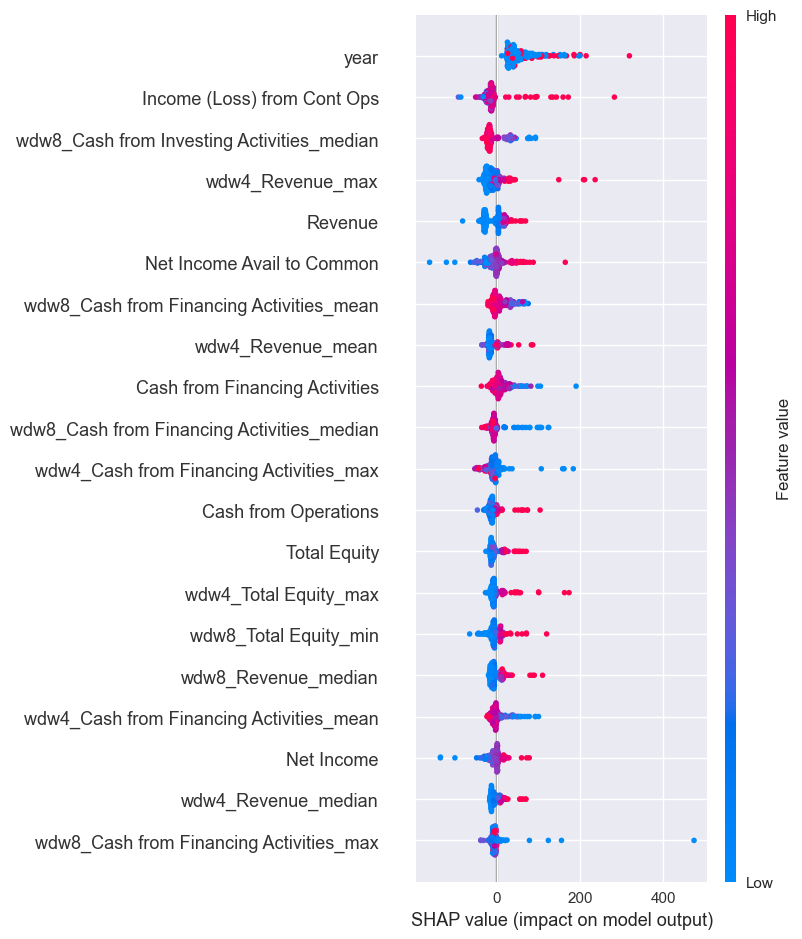

In [37]:
shap.summary_plot(shap_values[:,:-1], X_test_features)

P. S. wnw{n} - означает, что показатель рассчитывался по n последним кварталам. Например, wnw8_Cash from Investing Activities_median означает среднее значение Cash from Investing Activities за последние 8 кварталов, то есть за последние 2 года.